# Feature Extraction

## Packages

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import torch
import torchvision as tv
from PIL import Image

from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor

## Function

In [2]:
def custom_grayscale_threshold(img):
    img[img < 0.5] = 0                                   # Apply thresholding
    return img

## Preprocess

In [ ]:
dict_transform = {
    "Original": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
    ]),
    "BrightnessContrast": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2),
        tv.transforms.Resize((299, 299)),
    ]),
    "Base": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        Clahe(),
        tv.transforms.Resize((299, 299)),
    ]),
    "Normalize": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
        tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "Complex": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
        tv.transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal dengan probabilitas 50%
        tv.transforms.RandomRotation(degrees=15),  # Rotasi gambar antara -15 hingga 15 derajat
        tv.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translasi gambar 10% dari ukuran asli
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi warna
        tv.transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erasing sebagian gambar untuk regularisasi\
    ]),
    "Equalize": tv.transforms.Compose([
        tv.transforms.RandomEqualize(p=1.),
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
    ]),
    "EqualizeThreshold": tv.transforms.Compose([
        tv.transforms.RandomEqualize(p=1.),
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(custom_grayscale_threshold),
        tv.transforms.Resize((299, 299)),
    ]),
}

# setelah beberapa uji coba transformasi di atas, yg terbaik adalah menggunakan original dataset tanpa transformasi
name = "Original"
train_transform = dict_transform.get(name)
test_transform = dict_transform.get(name)

## Feature Extraction

Load dataset yg sudah di-augmentasi sebelumnya

In [ ]:
# load dataset dengan augmentation yg sama
list_aug = ["hflip"]

name = f'{name}_{"".join([aug.title() for aug in list_aug])}'
name_dataset = f'dataset_jpg_brightness_balance_augmentation_{"_".join([aug for aug in list_aug])}'

alex_1 = AlzheptionExtractor(
    path_dataset=f'../../asset/{name_dataset}/',
    test_size=0.2,                                  # data split 80% train, 20% test
    train_transform=train_transform,
    test_transform=test_transform,
)

alex_1.show_dataset_count()

Train dataset size : 684
Test dataset size  : 172


Tampilkan nama dataset, format `"NamaPreprocessing_NamaAugmentation"`

In [5]:
name

'Original_Hflip'

Sample dari test dataset sebelum di terapkan preprocessing

Get sample of original dataset (test) with index: 313



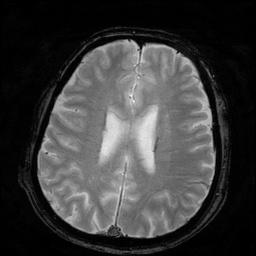

In [7]:
alex_1.get_sample_of_original_dataset(part="test")

Sample dari test dataset setelah di terapkan preprocessing

Get sample of preprocessed dataset (test) with index: 0



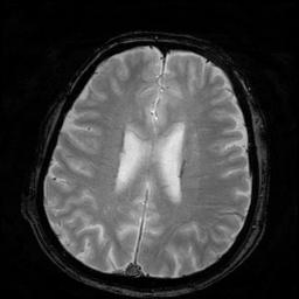

In [8]:
alex_1.get_sample_of_preprocessed_dataset(part="test")

## Feature Extraction

Load model InceptionV3

In [ ]:
# Load pre-trained InceptionV3 model and set as feature extractor
model = tv.models.inception_v3(weights=True)
model.aux_logits = False
model.fc = torch.nn.Identity()  # Replace fully connected layer with identity for feature extraction

# Move model to GPU if available and use DataParallel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs!')
    model = torch.nn.DataParallel(model)
model = model.to(device)

Extract Features

In [10]:
train_features, test_features = alex_1()

Extracting 'test': 100%|██████████| 1/1 [00:13<00:00, 13.87s/it]


In [11]:
train_features.shape, test_features.shape

((684, 2048), (172, 2048))

Save Features for classification with ELM

In [12]:
alex_1.save_extractor(dir_path="result/", suffix=f"_{name}")